# **Image Classification project using CNN**
Author: Himanshu Atri

Binary Image classification on dogs and cats dataset

dataset link: [https://www.kaggle.com/datasets/shaunthesheep/microsoft-catsvsdogs-dataset](http://)

# Import Neccessary Libraries

In [1]:
import os
import imghdr
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow  import keras
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from keras import Sequential
from tensorflow.keras import regularizers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Rescaling, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

2024-07-23 17:57:10.507730: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-23 17:57:10.507781: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-23 17:57:10.509287: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dir = '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages'

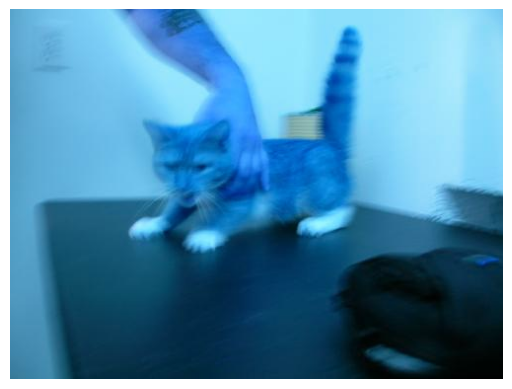

In [3]:
temp = cv2.imread('/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat/0.jpg')
plt.axis("off")
plt.imshow(temp)

In [4]:
cat_files = os.listdir('/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat')
dog_files = os.listdir('/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog')

print(f"Cats picture count: {len(cat_files)}\nDogs picture count: {len(dog_files)} ")

Cats picture count: 12501
Dogs picture count: 12501 


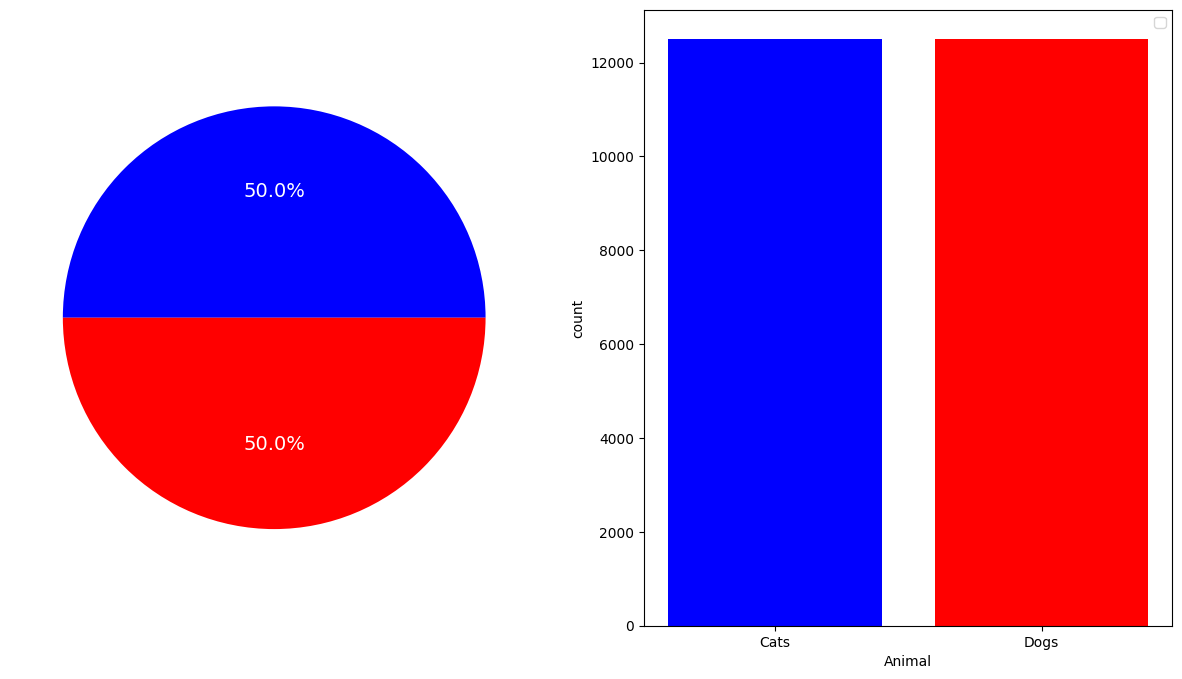

In [5]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.pie([len(cat_files), len(dog_files)], labels=['Cats', 'Dogs'], colors = ['blue', 'red'], autopct='%1.1f%%', textprops={'fontsize': 14, 'color': 'white'})
plt.subplot(1, 2, 2)
plt.bar(['Cats', 'Dogs'], [len(cat_files), len(dog_files)], color = ['blue', 'red'])
plt.xlabel('Animal')
plt.ylabel('count')

plt.legend()
plt.show()

In [6]:
dict_labels={'Cat':0,'Dog':1}

In [7]:
images_ds = []
label = []
c=0
for img_path, i in tqdm(zip(cat_files, range(0, 5000))):
    path = '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat'
    
    try:
        img = cv2.imread(os.path.join(path, str(img_path)))
        img=cv2.resize(img,(224,224),interpolation=cv2.INTER_AREA)
        images_ds.append(img)
        label.append(0)
    except Exception as e:
        c += 1

for img_path, i in tqdm(zip(dog_files, range(0, 5000))):
    path = '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog'
    try:
        img = cv2.imread(os.path.join(path, str(img_path)))
        img=cv2.resize(img,(224,224),interpolation=cv2.INTER_AREA)
        images_ds.append(img)
        label.append(1)
    except Exception as e:
        c += 1

print(c)

143it [00:00, 284.67it/s]Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
1622it [00:05, 270.32it/s]Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
5000it [00:18, 273.87it/s]
1413it [00:05, 283.75it/s]Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
2541it [00:09, 264.39it/s]Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
3906it [00:14, 281.31it/s]Warning: unknown JFIF revision number 0.00
5000it [00:18, 270.95it/s]

18


In [8]:
label = np.array(label)
images_ds = np.array(images_ds, dtype=np.float32)
images_ds /= 255.0

In [9]:
images_ds.shape, label.shape

((9982, 224, 224, 3), (9982,))

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(images_ds, label, test_size=0.2, random_state=1)

In [11]:
model = Sequential()
model.add(Input(shape=(224, 224, 3)))

model.add(Conv2D(32, kernel_size=(3,3), padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(64, kernel_size=(3,3), padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

model.add(Conv2D(128, kernel_size=(3,3), padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

# model.add(Conv2D(256, kernel_size=(3,3), padding='valid',activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
# model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

# model.add(Conv2D(512, kernel_size=(3,3), padding='valid',activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
# model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))


model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

In [12]:
# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(Y_train), y=Y_train)

# Convert the result to a dictionary
class_weights_dict = dict(enumerate(class_weights))

class_weights_dict

{0: 0.9991241241241241, 1: 1.000877412885435}

In [13]:
model.compile(optimizer="Adam", loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
path = '/kaggle/working/catVsdogs.keras'

model_checkpoint = ModelCheckpoint(
filepath=path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch',
)

model_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True,
    start_from_epoch=1
)

In [15]:
result = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=50, callbacks=[model_checkpoint, model_early_stopping])

Epoch 1/50


2024-07-23 17:58:14.800712: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49284: 7.84353, expected 6.92193
2024-07-23 17:58:14.800769: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49286: 7.76792, expected 6.84632
2024-07-23 17:58:14.800786: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49287: 6.15631, expected 5.23472
2024-07-23 17:58:14.800800: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49288: 6.71859, expected 5.797
2024-07-23 17:58:14.800811: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49289: 7.43913, expected 6.51753
2024-07-23 17:58:14.800821: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49290: 7.1783, expected 6.25671
2024-07-23 17:58:14.800832: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49291: 6.06838, expected 5.14679
2024-07-23 17:58:14.800844: E 

  4/250 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.4622 - loss: 6.3495 

I0000 00:00:1721757504.165330    1628 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


248/250 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5517 - loss: 4.2575

2024-07-23 17:58:40.228435: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.99007, expected 6.15692
2024-07-23 17:58:40.228505: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.39512, expected 5.56197
2024-07-23 17:58:40.228515: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.95928, expected 5.12613
2024-07-23 17:58:40.228523: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.97689, expected 5.14374
2024-07-23 17:58:40.228531: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.1288, expected 5.29565
2024-07-23 17:58:40.228539: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 6.45423, expected 5.62107
2024-07-23 17:58:40.228547: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 6.55749, expected 5.72433
2024-07-23 17:58:40.228555: E external/local_xla/xla/ser

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.5517 - loss: 4.2451

2024-07-23 17:58:52.839835: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.85897, expected 6.06893
2024-07-23 17:58:52.839892: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 5.96167, expected 5.17163
2024-07-23 17:58:52.839901: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 6.44264, expected 5.65259
2024-07-23 17:58:52.839910: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10: 6.23199, expected 5.44195
2024-07-23 17:58:52.839918: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 5.01164, expected 4.22159
2024-07-23 17:58:52.839926: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 5.90012, expected 5.11007
2024-07-23 17:58:52.839934: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13: 6.65641, expected 5.86637
2024-07-23 17:58:52.839942: E external/local_xla/xl


Epoch 1: val_loss improved from inf to 1.51801, saving model to /kaggle/working/catVsdogs.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 49s 125ms/step - accuracy: 0.5517 - loss: 4.2390 - val_accuracy: 0.5068 - val_loss: 1.5180
Epoch 2/50
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5818 - loss: 1.2793
Epoch 2: val_loss improved from 1.51801 to 1.23354, saving model to /kaggle/working/catVsdogs.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.5819 - loss: 1.2789 - val_accuracy: 0.5924 - val_loss: 1.2335
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6457 - loss: 1.0811
Epoch 3: val_loss improved from 1.23354 to 1.20795, saving model to /kaggle/working/catVsdogs.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.6458 - loss: 1.0809 - val_accuracy: 0.5478 - val_loss: 1.2079
Epoch 4/50
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6878 - loss: 0.9454
Epoch 4: val_loss improved from 1.20795 to 0.97233, saving model to /kaggle/working/

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 222, 222, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 109, 109, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 52, 52, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,859,461 (255.05 MB)

 Trainable params: 22,286,337 (85.02 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 44,572,676 (170.03 MB)

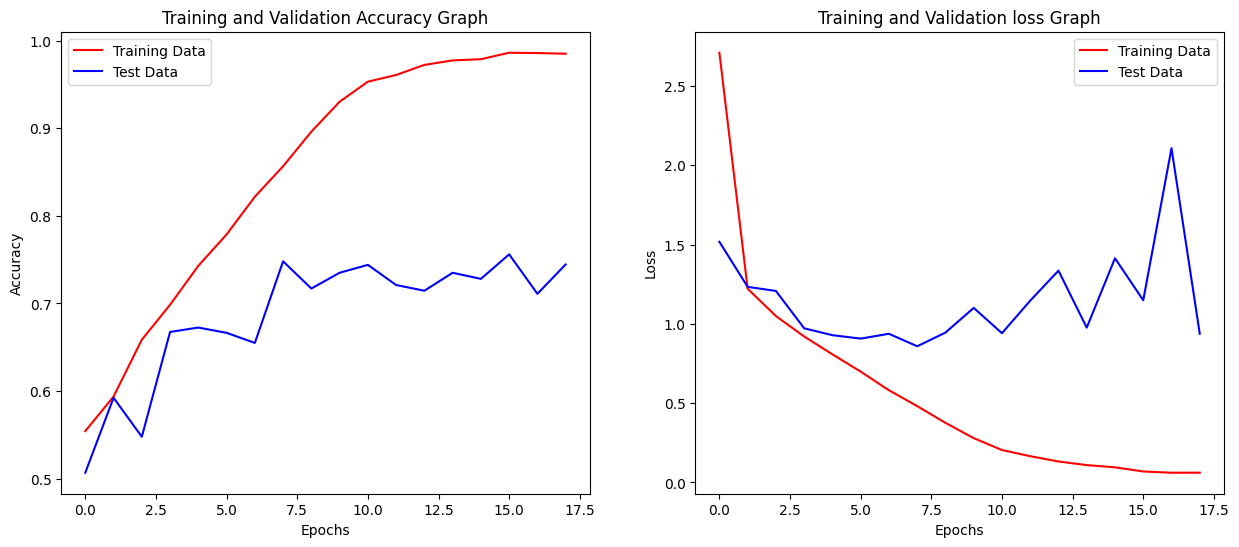

In [17]:
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.plot(result.history['accuracy'], color='r', label="Training Data")
plt.plot(result.history['val_accuracy'], color='b', label="Test Data")
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy Graph")

plt.subplot(1,2,2)
plt.plot(result.history['loss'], color='r', label="Training Data")
plt.plot(result.history['val_loss'], color='b', label="Test Data")
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation loss Graph")

plt.show()

In [18]:
predictions = model.predict(X_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


In [19]:
# Extract predicted labels from the prediction
prediction_list = []

for pred in predictions:
    prediction_list.append(int(np.round(pred[0])))

In [20]:
report = classification_report(Y_test, prediction_list)
print(report)

              precision    recall  f1-score   support

           0       0.72      0.81      0.76       996
           1       0.78      0.69      0.73      1001

    accuracy                           0.75      1997
   macro avg       0.75      0.75      0.75      1997
weighted avg       0.75      0.75      0.75      1997



In [21]:
def predict_animal(img_path):
    img = cv2.imread(img_path)
    img_resize = cv2.resize(img, (224, 224))
    img_resize = np.array(img_resize, dtype=np.float32)
    img_resize /= 255.0
    img_input = img_resize.reshape(1, 224, 224, 3)
    prediction = model.predict(img_input)
    
    if prediction[0][0] > 0.5:
        title = "It's a dog."
    else:
        title = "It's a cat."
        
    plt.figure(figsize=(3, 2))
    plt.axis("off")
    plt.title(title)
    plt.imshow(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


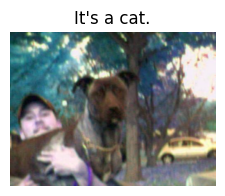

In [30]:
predict_animal("/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/1110.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


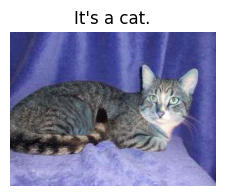

In [23]:
predict_animal("/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat/10004.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


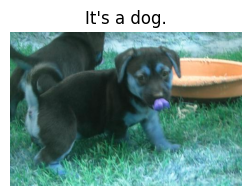

In [24]:
predict_animal("/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/3204.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


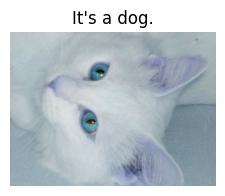

In [25]:
predict_animal("/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat/9876.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


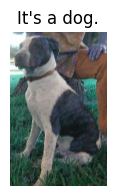

In [26]:
predict_animal("/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/7853.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


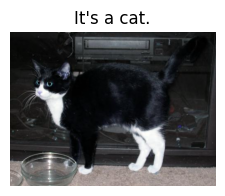

In [27]:
predict_animal("/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat/321.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


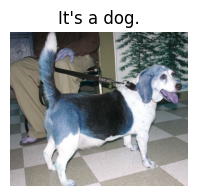

In [28]:
predict_animal("/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog/9898.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


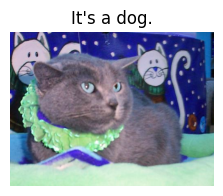

In [29]:
predict_animal("/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat/8989.jpg")